# EDA

<div style="text-align: right;">
KazutoMakino
</div>

デモンストレーション用に用意した温湿度センサから得られる湿度データについて，居室内雰囲気を正常，加湿器吐出部近傍湿度を異常と疑似的に定義し，これに対する異常検知／予知AIのプロトタイプの方向性を検討する．  
前提条件として，加湿器は就業時間中は常につけていて，暖房は寒さを感じた時に付け，十分な温度になったら電源を切っている．

---

## 0. 目次: <a class="anchor" id="0"></a>
1. [取得データの整形](#1)
2. [可視化](#2)

---

## 1. 取得データの整形 <a class="anchor" id="1"></a>  
[目次に戻る](#0)  

In [1]:
from pathlib import Path

温度／湿度のデータファイル： `./data/*.log`

In [2]:
cur_dir = Path("").resolve()
data_dir = cur_dir / "data"
flist = [v for v in data_dir.glob("*.txt")]

[v.name for v in flist]

['20220118180523357086.txt',
 '20220118192914980961.txt',
 '20220119092720689483.txt',
 '20220119122429859779.txt']

In [3]:
from datetime import datetime

print(f"{datetime.now().strftime('%Y/%m/%d')} では {len(flist)} 個のデータがある．")

2022/01/20 では 4 個のデータがある．


In [4]:
for fpath in flist:
    with fpath.open(mode="r", encoding="utf-8") as f:
        txt = f.read()
    print("****************************************")
    print(f"{fpath.name}, letters={len(txt)}")
    print("****************************************")
    print(txt[:300])
    print("...")
    print(txt[-300:])
    print()

****************************************
20220118180523357086.txt, letters=314850
****************************************
TimeStamp: 2022/01/18 18:05:36.168, ElapsedTime[s]: 51.81901, Temperature[degC]: 20.96514, Humidity[%]: 54.61814
TimeStamp: 2022/01/18 18:05:37.339934, ElapsedTime[s]: 53.156, Temperature[degC]: 20.96514, Humidity[%]: 54.61814
TimeStamp: 2022/01/18 18:05:38.678912, ElapsedTime[s]: 54.494, Temperatur
...
ime[s]: 3691.234, Temperature[degC]: 20.00648, Humidity[%]: 54.53727
TimeStamp: 2022/01/18 19:06:16.756211, ElapsedTime[s]: 3692.576, Temperature[degC]: 20.03586, Humidity[%]: 54.69749
TimeStamp: 2022/01/18 19:06:18.97351, ElapsedTime[s]: 3693.917, Temperature[degC]: 20.00648, Humidity[%]: 55.11864


****************************************
20220118192914980961.txt, letters=59462
****************************************
TimeStamp: 2022/01/18 19:29:14.688684, ElapsedTime[s]: 114.311, Temperature[degC]: 19.40032, Humidity[%]: 56.44159
TimeStamp: 2022/01/18 19:29:16.22

jsonっぽい見た目で保存してあるけど，時刻でも `:` を使っていたり，また，データ以外の文字列も入っていることに注意して，`pandas.DataFrame` 化する．作戦としてテキストとして読み込んだものについて，
- `split("\n")`
- 先頭が `TimeStamp:` でないものを除外
- `split(", ")`
- `split(": ", maxsplit=1)`
を施したのちに `pandas.DataFrame` 化する．

In [5]:
import pandas as pd

In [6]:
# init
dfs = {}

# loop: files
for fpath in flist:
    # file open
    with fpath.open(mode="r", encoding="utf-8") as f:
        # read
        txt = f.read()

    # split with "\n"
    lines = txt.split("\n")

    # exclude not line.startswith("TimeStamp: ")
    lines = [v for v in lines if v.startswith("TimeStamp: ")]

    # split with ", "
    mat = [v.split(", ") for v in lines if v]

    # split with ": ", maxsplit=1
    item_tuples =  [[vv.split(": ", maxsplit=1) for vv in v if vv] for v in mat if v]
    columns = [v[0] for v in item_tuples[0]]
    values = [[vv[1] for vv in v] for v in item_tuples]

    # make dataframe
    df = pd.DataFrame(data=values, columns=columns)

    # cast
    for col in df.columns:
        if col=="TimeStamp":
            df[col] = pd.to_datetime(df[col])
        else:
            df[col] = df[col].astype(float)

    # show
    print(df.info())
    print()

    # add to dfs
    dfs[fpath.stem] = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TimeStamp          2730 non-null   datetime64[ns]
 1   ElapsedTime[s]     2730 non-null   float64       
 2   Temperature[degC]  2730 non-null   float64       
 3   Humidity[%]        2730 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 85.4 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   TimeStamp          520 non-null    datetime64[ns]
 1   ElapsedTime[s]     520 non-null    float64       
 2   Temperature[degC]  520 non-null    float64       
 3   Humidity[%]        520 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 16.4 KB
None

In [7]:
dfs.keys()

dict_keys(['20220118180523357086', '20220118192914980961', '20220119092720689483', '20220119122429859779'])

無事，`pandas.DataFrame` に変換できた．次に可視化を行う．

---

## 2. 可視化 <a class="anchor" id="2"></a>  
[目次に戻る](#0)  

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

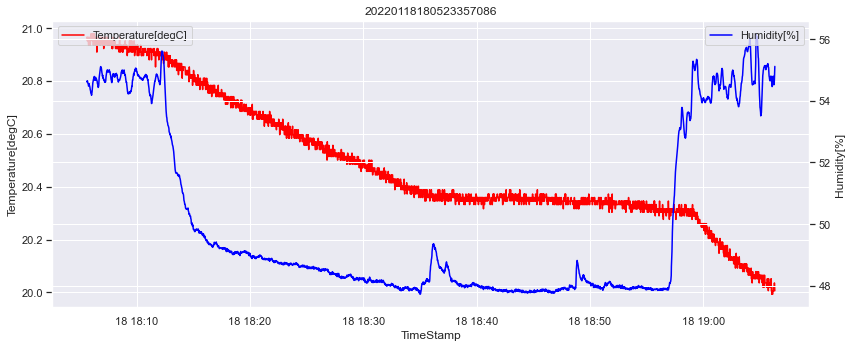

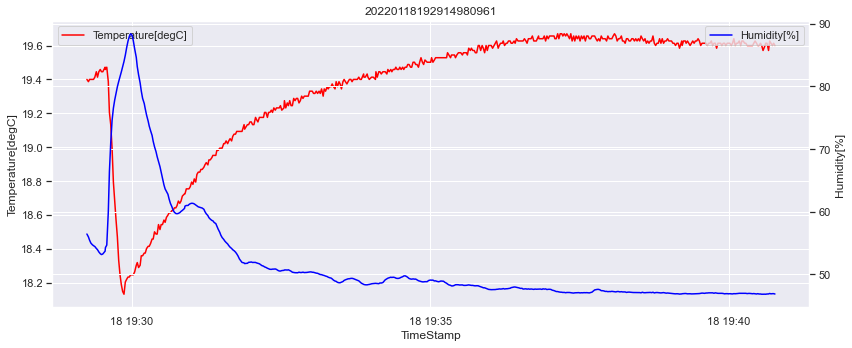

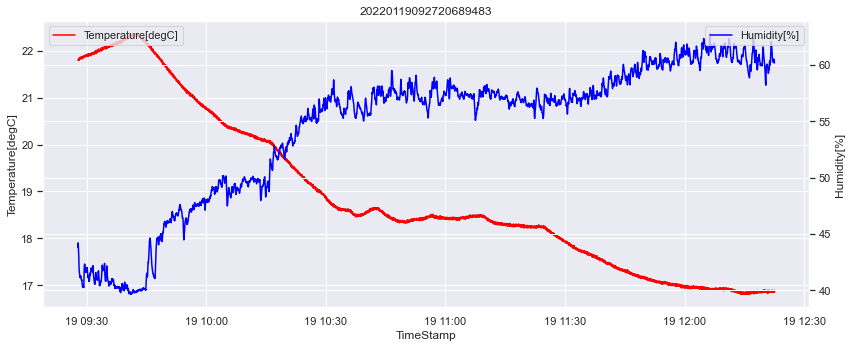

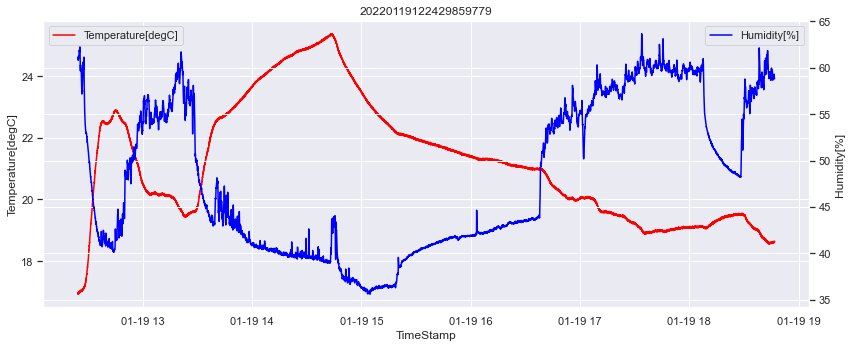

In [9]:
xcol = "TimeStamp"
ycol1 = "Temperature[degC]"
ycol2 = "Humidity[%]"

for k,df in dfs.items():
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.set_xlabel(xcol)
    ax1.set_ylabel(ycol1)
    ax2.set_ylabel(ycol2)
    ax1.plot(df[xcol], df[ycol1], color="red", label=ycol1)
    ax2.plot(df[xcol], df[ycol2], color="blue", label=ycol2)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.title(k)
    fig.tight_layout()
    plt.show()
    plt.clf()
    plt.close("all")

- 赤の実線（第1縦軸）：居室内温度[℃]，青の実線（第2縦軸）：居室内湿度[%] を表す
- 第1第2縦軸のスケールが異なることに注意が必要
- 上記プロットから，温度と湿度はおおよそトレードオフの関係にある
- 暖房／加湿器／換気扇の ON / OFF や窓の開閉をしているため，30分や1時間単位で大きな変化する
- 上から2段目のプロットについて，`18 19:30` における温度と湿度のピークが見られるが，これは，加湿器吐出部近傍に近づけて測定したデータで，これ以外の日時では加湿器吐出部近傍にはセンサを近づけたデータを取っていない
- 上記ピークは，疑似的な異常として温湿度センサを加湿器吐出孔に近づけた時のデータだが，特に湿度は定常状態よりも2倍程度まで急上昇している．  

温度／湿度における度数分布を棒グラフ及びカーネル密度推定で，この度数の平均を一点鎖線にて以下にプロットする．

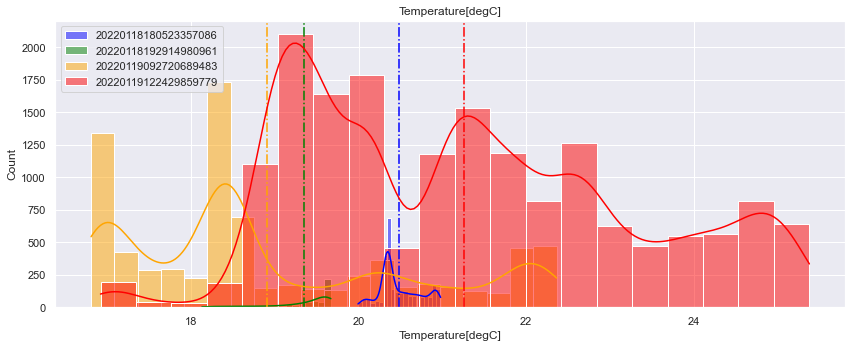

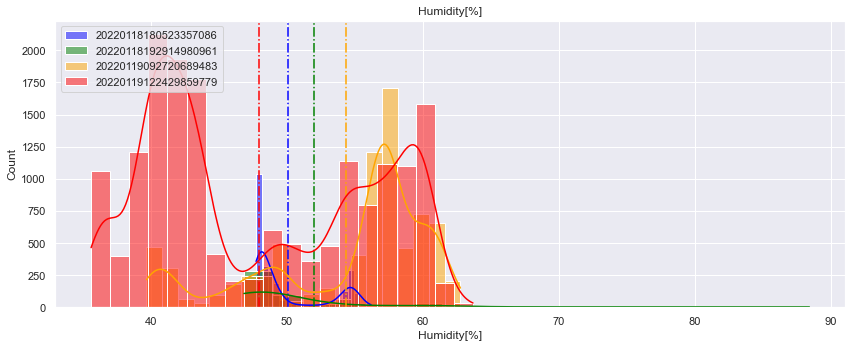

In [10]:
xcol1 = "Temperature[degC]"
xcol2 = "Humidity[%]"
ycol = "Count"

# init
color = ["blue", "green", "orange", "red"]
bins = 20

# temperature
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()
ax.set_xlabel(xcol1)
ax.set_ylabel(ycol)
for i, k_df in enumerate(dfs.items()):
    # unpack
    k, df = k_df
    # ax.hist(df[xcol1], bins=50)
    ax = sns.histplot(df[xcol1], bins=bins, kde=True, label=k, color=color[i])
    ax.axvline(df[xcol1].mean(), color=color[i], linestyle="-.")
ax.legend(loc="upper left")
#ax.set_yscale("log")
#ax.set_ylim(0.9)
plt.title(xcol1)
fig.tight_layout()
plt.show()
plt.close("all")

# humidity
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()
ax.set_xlabel(xcol2)
ax.set_ylabel(ycol)
for i, k_df in enumerate(dfs.items()):
    # unpack
    k, df = k_df
    # ax.hist(df[xcol1], bins=50)
    ax = sns.histplot(df[xcol2], bins=bins, kde=True, label=k, color=color[i])
    ax.axvline(df[xcol2].mean(), color=color[i], linestyle="-.")
ax.legend(loc="upper left")
#ax.set_yscale("log")
#ax.set_ylim(0.9)
plt.title(xcol2)
fig.tight_layout()
plt.show()

レコード数が大きい順に，赤 > オレンジ > 青 > 緑 となっているが，上記のように，正規化されていないデータセットの度数分布は潰れてしまう．  
また，正規化しても棒グラフが重なりあって見にくいので，正規化したカーネル密度推定のみをプロットする．

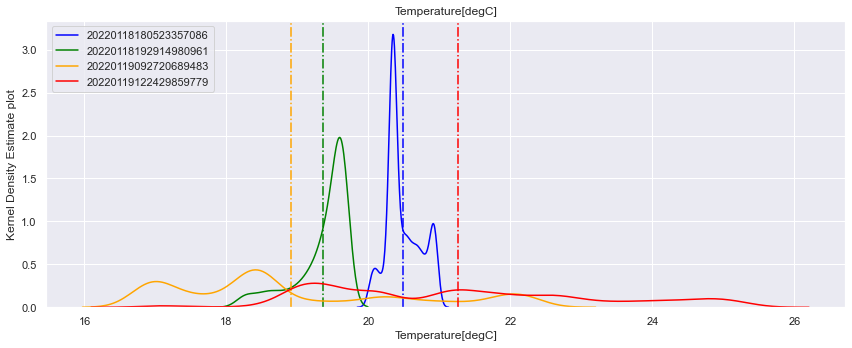

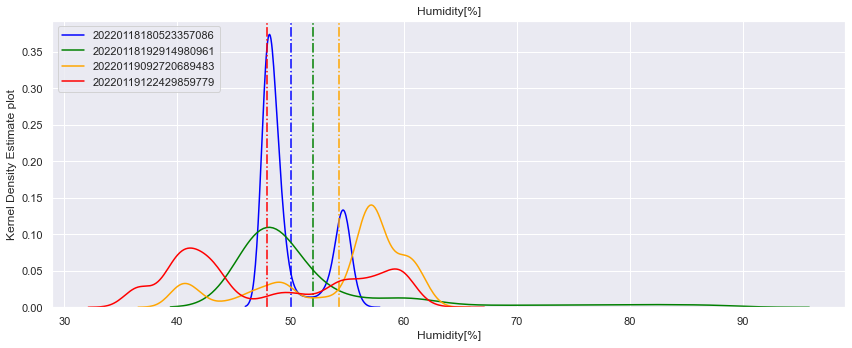

In [11]:
xcol1 = "Temperature[degC]"
xcol2 = "Humidity[%]"
ycol = "Kernel Density Estimate plot"

# init
color = ["blue", "green", "orange", "red"]

# temperature
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()
ax.set_xlabel(xcol1)
ax.set_ylabel(ycol)
for i, k_df in enumerate(dfs.items()):
    # unpack
    k, df = k_df
    ax = sns.kdeplot(df[xcol1], label=k, color=color[i])
    ax.axvline(df[xcol1].mean(), color=color[i], linestyle="-.")
ax.legend(loc="upper left")
plt.title(xcol1)
fig.tight_layout()
plt.show()
plt.close("all")

# humidity
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot()
ax.set_xlabel(xcol2)
ax.set_ylabel(ycol)
for i, k_df in enumerate(dfs.items()):
    # unpack
    k, df = k_df
    ax = sns.kdeplot(df[xcol2], label=k, color=color[i])
    ax.axvline(df[xcol2].mean(), color=color[i], linestyle="-.")
ax.legend(loc="upper left")
plt.title(xcol2)
fig.tight_layout()
plt.show()

- 温度において，青と緑は裾野が狭く，オレンジと赤は裾野が広い．これは，温度変化はエアコンや換気扇の ON / OFF に大きく左右されるが，前者はデータ取得した時間が短く，エアコンや換気扇を操作しなかったことに起因する．後者は，測定中にエアコンや換気扇の操作があった．
- 湿度は相対湿度[%]なので，温度上昇に伴い湿度は低下する．
- 湿度において，高い温度を示したオレンジと赤にて，低湿度の期間があったことが示される．
- 湿度分布の緑のプロットにおいて，分布の裾野は80[%]を超えているが，これは，疑似的な異常データとして，湿度センサを加湿器吐出部近傍に近づけて取得したことによる．

上記は取得したデータファイルごとに別々にプロットしてあるが，同種のデータなので，全データを一括で考えてプロットしても良いため，データフレームを結合して可視化する．

In [12]:
# init
df_all = pd.DataFrame()

# concat
for df in dfs.values():
    df_all = pd.concat([df_all, df])
df_all.reset_index(drop=True, inplace=True)

df_all.tail(3)

,TimeStamp,ElapsedTime[s],Temperature[degC],Humidity[%]
28293,2022-01-19 18:46:41.771086,23042.34,18.61257,58.87999
28294,2022-01-19 18:46:43.103816,23043.68,18.61257,58.82048
28295,2022-01-19 18:46:44.437707,23045.01,18.62592,58.83421


In [13]:
df_all.describe()[["Temperature[degC]", "Humidity[%]"]]

,Temperature[degC],Humidity[%]
count,28296.000000,28296.000000
mean,20.496159,49.983076
std,2.039368,7.807626
min,16.810100,35.591670
25%,19.063860,42.195390
50%,20.316250,49.726100
75%,21.838330,57.169450
max,25.376520,88.407730


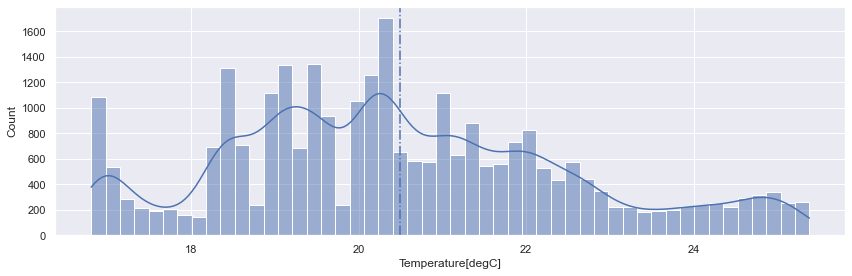

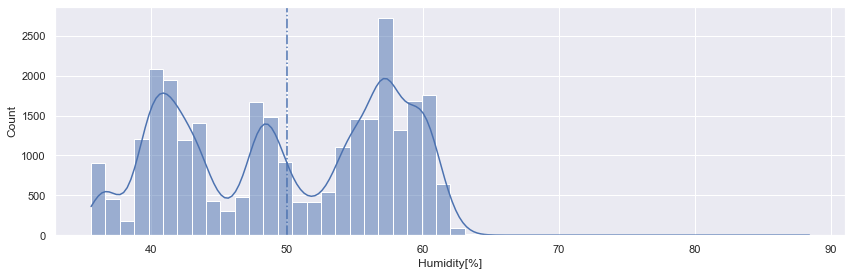

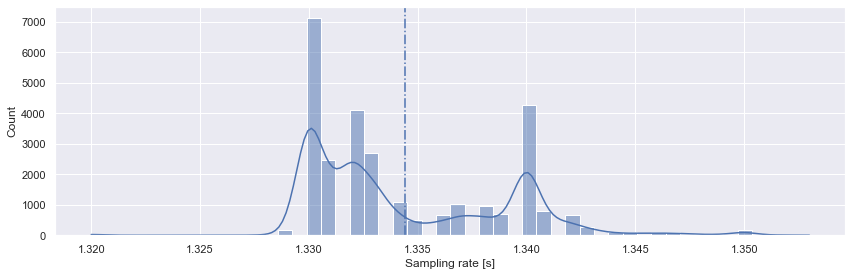

In [14]:
xcol1 = "Temperature[degC]"
xcol2 = "Humidity[%]"
ycol = "Count"

# init
bins = 50

# plot
for xcol in [xcol1, xcol2]:
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot()
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax = sns.histplot(df_all[xcol], bins=bins, kde=True)
    ax.axvline(df_all[xcol].mean(), linestyle="-.")
    fig.tight_layout()
    plt.show()
    plt.close("all")

# calc delta t
delta_t = []
for df in dfs.values():
    v = df["ElapsedTime[s]"]
    delta_t.extend([v.iloc[i] - v.iloc[i - 1] for i in range(len(df)) if i!=0])

# plot
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot()
ax.set_xlabel("Sampling rate [s]")
ax.set_ylabel(ycol)
ax = sns.histplot(delta_t, bins=bins, kde=True)
ax.axvline(sum(delta_t)/len(delta_t), linestyle="-.")
fig.tight_layout()
plt.show()

- 温度データは，比較的過ごしやすいようにするため温度調節をしているため，ca.18～22 における割合が大きい
- 湿度データについては，分布の3つピークが特徴的．疑似的な異常として，加湿器吐出部近傍の湿度を計測したときに湿度80[%]以上を示していたが，上記の分布から見てもこの領域は外れ値であることが示される．
- 下段はサンプリングレートを示しており，センサデータを処理するデバイス側に 1 [s] の待ち時間を設定しているため基本的にサンプリングレートは 1 [s] となるが，サンプリングレート自体のばらつきは小さい．

湿度分布の3つのピークについて，温度との関係性を見る．

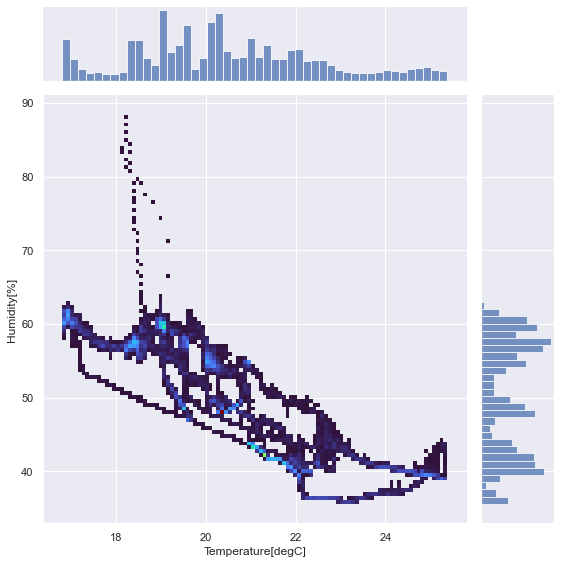

In [15]:
sns.jointplot(
    data=df_all,
    x="Temperature[degC]",
    y="Humidity[%]",
    kind="hist",
    cmap="turbo",
    height=8,
    bins=100
)
plt.show()

- 横軸：温度，縦軸：湿度のヒストグラム
- 真ん中のプロットは，温度と湿度の度数を大きさを色で表していて，大きくなるに従い，寒色から暖色へと変化させている
- 湿度 60[%]近傍の領域は，低温度環境下における飽和水蒸気量の減少に伴う相対湿度の上昇に起因している．
- これと逆に，湿度 40[%]近傍の領域は，暖房を入れたことにより，飽和水蒸気量の増加に伴う相対湿度の減少に起因している．
- 湿度 50[%]近傍の領域は，居室内温度を約20[degC]を目指して暖房をon/offすることが多いらしく，これと加湿器およびセンサの位置関係に起因している．